# Assignment 5

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Input, Flatten, Dropout, BatchNormalization
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## FCN Moldel

### Set the random seed

In [ ]:
tf.random.set_seed(42)

### Load the data set

In [ ]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
data_depth = len(set(y_train))
y_train=tf.one_hot(y_train,depth=data_depth)
y_test=tf.one_hot(y_test,depth=data_depth)
X_train = tf.expand_dims(X_train, axis = -1)
X_test = tf.expand_dims(X_test, axis = -1)

4423680/4422102 [==============================] - 0s 0us/step


### Make Pipline 
Set batch_Size to 32 and Normlize the images

In [ ]:
def data_preproces(img, label):
  img=tf.image.convert_image_dtype(img,dtype=tf.float32)
  return img, label


In [ ]:
def dataset_creator(X, y):
  data = tf.data.Dataset.from_tensor_slices((X, y))
  data=data.shuffle(1024)
  data=data.map(data_preproces,num_parallel_calls=tf.data.experimental.AUTOTUNE)
  data=data.batch(32)
  data = data.prefetch(tf.data.experimental.AUTOTUNE)
  return data

In [ ]:
train_data = dataset_creator(X_train, y_train)
test_data = dataset_creator(X_test, y_test)

### Make the model

In [ ]:
model_fcn = tf.keras.models.Sequential([tf.keras.layers.Input([28,28, 1])
            ,Flatten()
            ,Dense(16, activation='relu')
            ,Dense(10,activation=tf.nn.softmax)
]
)

### Train the mode

In [ ]:
model_fcn.compile(optimizer='adam',loss=tf.losses.CategoricalCrossentropy(),metrics=['acc'])
model_fcn.fit(train_data,epochs=5,validation_data=test_data)

Epoch 1/5
1875/1875 [==============================] - 7s 3ms/step - loss: 0.8352 - acc: 0.7175 - val_loss: 0.4844 - val_acc: 0.8349
Epoch 2/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.4468 - acc: 0.8451 - val_loss: 0.4464 - val_acc: 0.8433
Epoch 3/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.4091 - acc: 0.8546 - val_loss: 0.4262 - val_acc: 0.8474
Epoch 4/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3903 - acc: 0.8601 - val_loss: 0.4243 - val_acc: 0.8512
Epoch 5/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3781 - acc: 0.8638 - val_loss: 0.4114 - val_acc: 0.8561


### Plot the train_loss vs val_loss

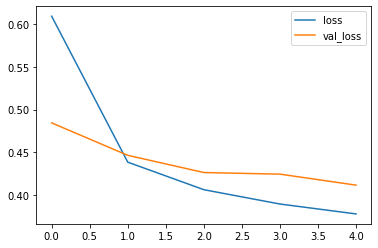

In [ ]:
hist = pd.DataFrame(model_fcn.history.history)
hist[['loss', 'val_loss']].plot.line()

In [ ]:
result_test =  model_fcn.evaluate(test_data)
result_train =  model_fcn.evaluate(train_data)

1875/1875 [==============================] - 4s 2ms/step - loss: 0.3605 - acc: 0.8724


In [ ]:
print('test_accuracy = ', round(result_test[1],2)*100, '%')
print('train_accuracy = ', round(result_train[1],2)*100, '%')

test_accuracy =  86.0 %
train_accuracy =  87.0 %


## CNN Model

### Set the random seed

In [ ]:
tf.random.set_seed(42)

### Make the model

In [ ]:

model_cnn = tf.keras.models.Sequential([
             tf.keras.layers.Input([28,28, 1])   
            ,Conv2D(64, 5, activation='relu',
                    padding = 'same',
                    kernel_initializer='he_normal')
            
            ,Conv2D(64, 5, activation='relu',
                          padding = 'same',)
            
            ,tf.keras.layers.BatchNormalization()

            #This version performs the same function as Dropout,
            #however, it drops entire 2D feature maps instead of individual elements. 
            ,tf.keras.layers.SpatialDropout2D(0.3)

            ,MaxPooling2D()
            ,Conv2D(128, 3, activation='relu',
                    padding = 'same',kernel_initializer='he_normal')
            ,Conv2D(128, 3, activation='relu',
                    padding = 'same', kernel_regularizer = 'l2')
            ,tf.keras.layers.SpatialDropout2D(0.3)
            ,tf.keras.layers.BatchNormalization()
            ,MaxPooling2D()
            ,Conv2D(256, 3, activation='relu',
                    padding = 'same',kernel_initializer='he_normal')
            ,Conv2D(256, 3, activation='relu',
                    padding = 'same', kernel_regularizer = 'l2')
            ,tf.keras.layers.SpatialDropout2D(0.3)
            ,tf.keras.layers.BatchNormalization()
            ,MaxPooling2D()
            ,Conv2D(512, 3, activation='relu',
                    padding = 'same',kernel_initializer='he_normal')
            ,Conv2D(512, 3, activation='relu',
                    padding = 'same', kernel_regularizer = 'l2')
            ,tf.keras.layers.SpatialDropout2D(0.3)
            ,tf.keras.layers.BatchNormalization()

            

            ,Flatten()
            ,Dense(1024, activation='relu', kernel_regularizer = 'l2')
            ,Dropout(0.3)
            ,Dense(10,activation=tf.nn.softmax)
]
)

### Train the mode

In [ ]:
## Make learning rate scheduler
def scheduler(epoch, lr):
  if epoch < 10:
    return lr
  else:
    if lr > 1e-5:
       lr = lr*tf.math.exp(-0.03)
    return lr

lr_schedul = tf.keras.callbacks.LearningRateScheduler(scheduler)


In [ ]:
model_cnn.compile(optimizer=tf.optimizers.Adamax(learning_rate=1e-3),
                  loss='categorical_crossentropy', metrics=['acc'])

model_cnn.fit(train_data, epochs=100, validation_data=test_data, callbacks=[lr_schedul])

Epoch 1/100
1875/1875 [==============================] - 33s 17ms/step - loss: 9.0639 - acc: 0.7265 - val_loss: 1.0111 - val_acc: 0.8503
Epoch 2/100
1875/1875 [==============================] - 32s 17ms/step - loss: 0.8723 - acc: 0.8500 - val_loss: 0.6151 - val_acc: 0.8693
Epoch 3/100
1875/1875 [==============================] - 32s 17ms/step - loss: 0.6025 - acc: 0.8762 - val_loss: 0.5384 - val_acc: 0.8849
Epoch 4/100
1875/1875 [==============================] - 32s 17ms/step - loss: 0.5392 - acc: 0.8858 - val_loss: 0.4802 - val_acc: 0.8991
Epoch 5/100
1875/1875 [==============================] - 32s 17ms/step - loss: 0.4915 - acc: 0.8947 - val_loss: 0.4745 - val_acc: 0.8942
Epoch 6/100
1875/1875 [==============================] - 32s 17ms/step - loss: 0.4648 - acc: 0.8986 - val_loss: 0.4429 - val_acc: 0.9069
Epoch 7/100
1875/1875 [==============================] - 32s 17ms/step - loss: 0.4442 - acc: 0.9039 - val_loss: 0.4244 - val_acc: 0.9105
Epoch 8/100
1875/1875 [==================

### Plot the train_loss vs val_loss

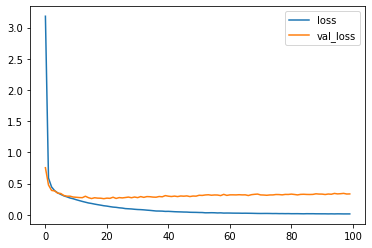

In [ ]:
hist = pd.DataFrame(model_cnn.history.history)
hist[['loss', 'val_loss']].plot.line()

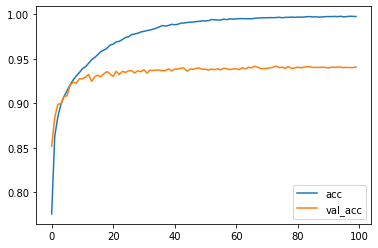

In [ ]:
hist[['acc', 'val_acc']].plot.line()

In [ ]:
result_test =  model_cnn.evaluate(test_data)
result_train =  model_cnn.evaluate(train_data)

1875/1875 [==============================] - 10s 5ms/step - loss: 0.0051 - acc: 1.0000


In [ ]:
print('test_accuracy = ', round(result_test[1],3)*100, '%')
print('train_accuracy = ', round(result_train[1],3)*100, '%')

test_accuracy =  94.1 %
train_accuracy =  100.0 %
